In [1]:
import spacy
from spacy.training import Example
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from spacy.util import minibatch, compounding
from spacy.scorer import Scorer
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import ast
import seaborn as sns
from tqdm import tqdm

print("Libraries imported")

Libraries imported


In [2]:

dataset_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/tokens/token.csv"
model_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/spacy_less_data/"

print("Paths defined")

Paths defined


In [3]:
# Chargement du modèle spaCy
def load_model_with_progress(model_name):
    with tqdm(total=100, desc="Loading spaCy model") as pbar:
        nlp = spacy.load(model_name)
        pbar.update(100)
    return nlp

nlp = load_model_with_progress("fr_core_news_lg")
print("\nspaCy model Loaded successfully")

Loading spaCy model: 100%|██████████| 100/100 [00:12<00:00,  7.85it/s]


spaCy model Loaded successfully


In [4]:
ner = nlp.get_pipe("ner")
# Ajout des étiquettes personnalisées
labels = ["DEP", "ARR"]
for label in labels:
    ner.add_label(label)

print("Personalised labels added successfully")

Personalised labels added successfully


In [5]:

# Chargement des données avec une barre de progression
def load_dataset_with_progress(dataset_path):
    with tqdm(total=100, desc="Loading dataset\n") as pbar:
        dataset = pd.read_csv(dataset_path, delimiter=';', quotechar='"', names=["text", "tokens", "ner_tags", "spacy_ner_tags"])
        pbar.update(100)
    return dataset

dataset = load_dataset_with_progress(dataset_path)
print("Loaded dataset successfully")

Loading dataset
Loading dataset  | 0/100 [00:00<?, ?it/s]
Loading dataset██| 100/100 [00:04<00:00, 22.77it/s]
: 100%|██████████| 100/100 [00:04<00:00, 22.76it/s]

Loaded dataset successfully


In [6]:
# *** Limiter le dataset à 80 000 lignes ***
print("Limiting the dataset to 80,000 lines...")
dataset = dataset.head(80000)
print(f"Dataset limited to {len(dataset)} lines.")

Limiting the dataset to 80,000 lines...
Dataset limited to 80000 lines.


In [7]:
# Normalisation des annotations
def safe_eval(val):
    try:
        val = val.replace('""', "'").replace("'", '"')
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

def is_entity_well_aligned(text, start, end):
    if start > 0 and text[start - 1].isalnum():
        return False
    if end < len(text) and text[end].isalnum():
        return False
    return True

In [8]:
# Préparation des données d'entraînement
print("Preparing training data...")
CONVERTED_TRAIN_DATA = []
misaligned_examples_count = 0

for _, item in tqdm(dataset.iterrows(), total=len(dataset)):
    tokens_str = item['tokens'].replace("'", '"')
    spacy_ner_tags_str = item['spacy_ner_tags'].replace("'", '"') if pd.notnull(item['spacy_ner_tags']) else None

    tokens = safe_eval(tokens_str)
    if tokens is None:
        continue

    if spacy_ner_tags_str:
        annotations = safe_eval(spacy_ner_tags_str)
        if annotations:
            entities = []
            for annotation in annotations:
                start, end, label = annotation['start'], annotation['end'], annotation['label']
                if is_entity_well_aligned(" ".join(tokens), start, end):
                    entities.append((start, end, label))
            CONVERTED_TRAIN_DATA.append((" ".join(tokens), {"entities": entities}))
        else:
            misaligned_examples_count += 1
    else:
        misaligned_examples_count += 1

print("\nTraining data prepared successfully")

Preparing training data...


100%|██████████| 80000/80000 [00:21<00:00, 3672.80it/s]


Training data prepared successfully


In [9]:
examples = []
for text, annotations in CONVERTED_TRAIN_DATA:
    try:
        doc = nlp.make_doc(text)
        examples.append(Example.from_dict(doc, annotations))
    except ValueError:
        continue

C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Trouve- moi un itinéraire d ax les thermes vers DR..." with entities "[(28, 42, 'ARR'), (48, 62, 'DEP')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Je cherche un moyen d aller de Lille à Trier Hbf T..." with entities "[(31, 36, 'DEP'), (39, 57, 'ARR')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Planifie

In [10]:
# Répartition des données en ensembles d'entraînement, test et validation
train_data, test_valid_data = train_test_split(examples, test_size=0.5, random_state=42)
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)

print(f"Train data: {len(train_data)} examples")
print(f"Test data: {len(test_data)} examples")
print(f"Validation data: {len(valid_data)} examples")

Train data: 27592 examples
Test data: 13796 examples
Validation data: 13797 examples


In [11]:
# Entraînement du modèle
def evaluate(nlp, examples):
    scorer = Scorer()
    examples_to_score = []
    for example in examples:
        pred_doc = nlp(example.text)
        scored_example = Example(pred_doc, example.reference)
        examples_to_score.append(scored_example)
    return scorer.score(examples_to_score)

losses_hist, f1_hist, recall_hist, precision_hist = [], [], [], []
epochs = 20

with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    optimizer = nlp.begin_training()
    for epoch in tqdm(range(epochs), desc="Training model"):
        random.shuffle(train_data)
        losses = {}
        batches = list(minibatch(train_data, size=compounding(16.0, 64.0, 1.001)))
        for batch in tqdm(batches, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            nlp.update(batch, drop=0.2, losses=losses, sgd=optimizer)
        print(f"Loss at epoch {epoch}: {losses}")
        losses_hist.append(losses['ner'])

        # Validation
        valid_scores = evaluate(nlp, valid_data)
        f1_hist.append(valid_scores['ents_f'])
        recall_hist.append(valid_scores['ents_r'])
        precision_hist.append(valid_scores['ents_p'])

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Loss at epoch 0: {'ner': 27605.723214872956}


Training model:   5%|▌         | 1/20 [05:11<1:38:42, 311.73s/it]

Loss at epoch 1: {'ner': 17078.694393842932}


Training model:  10%|█         | 2/20 [10:15<1:32:02, 306.83s/it]

Loss at epoch 2: {'ner': 13110.134418185824}


Training model:  15%|█▌        | 3/20 [15:00<1:24:12, 297.23s/it]

Loss at epoch 3: {'ner': 11277.554171995289}


Training model:  20%|██        | 4/20 [20:45<1:24:15, 315.99s/it]

Loss at epoch 4: {'ner': 10172.671931059136}


Training model:  25%|██▌       | 5/20 [26:39<1:22:23, 329.54s/it]

Loss at epoch 5: {'ner': 9499.634561488381}


Training model:  30%|███       | 6/20 [31:49<1:15:22, 323.01s/it]

Loss at epoch 6: {'ner': 9045.264874731682}


Training model:  35%|███▌      | 7/20 [39:01<1:17:42, 358.62s/it]

Loss at epoch 7: {'ner': 8633.545726874228}


Training model:  40%|████      | 8/20 [44:36<1:10:14, 351.21s/it]

Loss at epoch 8: {'ner': 8238.089360448997}


Training model:  45%|████▌     | 9/20 [48:42<58:18, 318.09s/it]  

Loss at epoch 9: {'ner': 7985.045990733689}


Training model:  50%|█████     | 10/20 [53:44<52:11, 313.17s/it]

Loss at epoch 10: {'ner': 7739.003378397062}


Training model:  55%|█████▌    | 11/20 [59:17<47:55, 319.45s/it]

Loss at epoch 11: {'ner': 7503.207652442815}


Training model:  60%|██████    | 12/20 [1:04:11<41:32, 311.52s/it]

Loss at epoch 12: {'ner': 7286.6252631327225}


Training model:  65%|██████▌   | 13/20 [1:08:42<34:54, 299.25s/it]

Loss at epoch 13: {'ner': 7154.012746792182}


Training model:  70%|███████   | 14/20 [1:14:00<30:29, 304.96s/it]

Loss at epoch 14: {'ner': 7043.0418127861785}


Training model:  75%|███████▌  | 15/20 [1:19:03<25:22, 304.41s/it]

Loss at epoch 15: {'ner': 6868.151253689751}


Training model:  80%|████████  | 16/20 [1:23:46<19:51, 297.93s/it]

Loss at epoch 16: {'ner': 6730.480156287106}


Training model:  85%|████████▌ | 17/20 [1:28:44<14:53, 297.85s/it]

Loss at epoch 17: {'ner': 6640.625354089174}


Training model:  90%|█████████ | 18/20 [1:33:45<09:57, 298.80s/it]

Loss at epoch 18: {'ner': 6550.314888783136}


Training model:  95%|█████████▌| 19/20 [1:38:42<04:58, 298.24s/it]

Loss at epoch 19: {'ner': 6414.914585115462}


Training model: 100%|██████████| 20/20 [1:43:46<00:00, 311.31s/it]


In [12]:
# Évaluation
valid_scores = evaluate(nlp, valid_data)
print(f"Validation F1 Score: {valid_scores['ents_f']}, Precision: {valid_scores['ents_p']}, Recall: {valid_scores['ents_r']}")

output_dir = Path(model_path)
output_dir.mkdir(parents=True, exist_ok=True)
nlp.to_disk(output_dir)

test_scores = evaluate(nlp, test_data)
print(f"Test F1 Score: {test_scores['ents_f']}, Precision: {test_scores['ents_p']}, Recall: {test_scores['ents_r']}")

Validation F1 Score: 0.8563211951447246, Precision: 0.8581480649749232, Recall: 0.8545020870602266
Test F1 Score: 0.8538639791076618, Precision: 0.8508283242926257, Recall: 0.8569213732004429


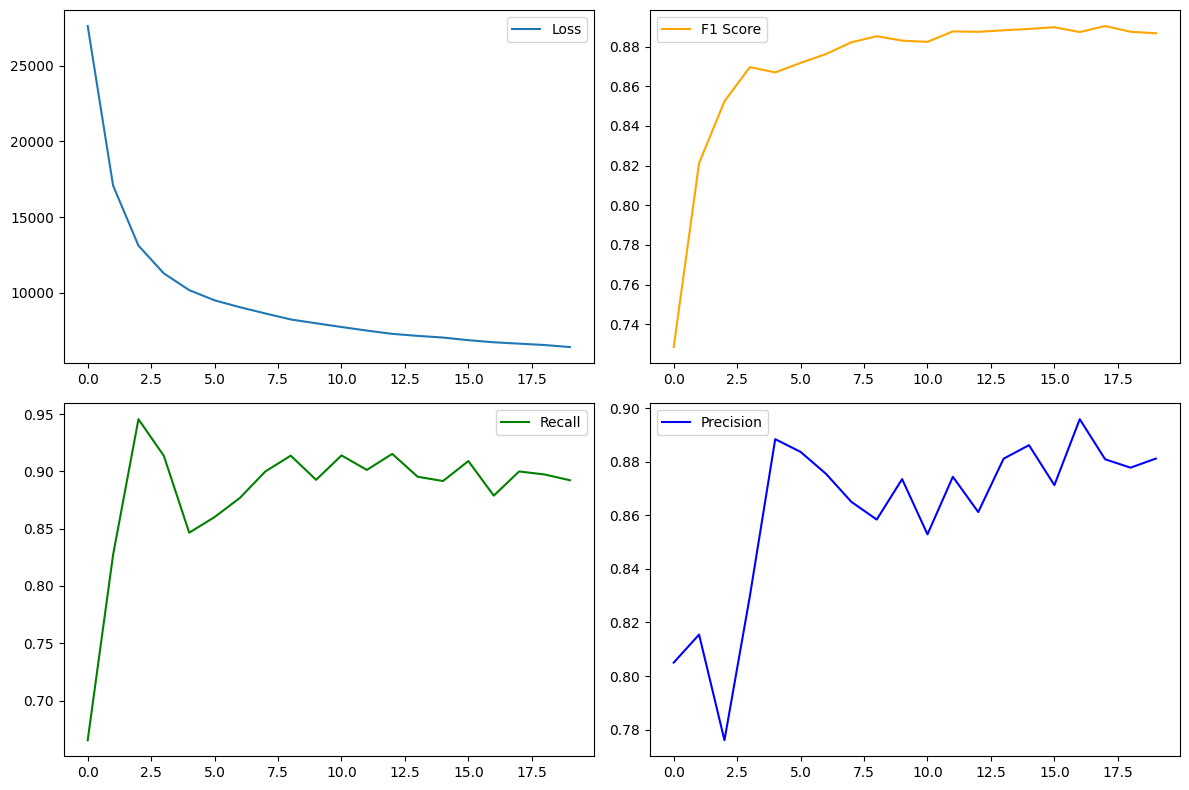

In [13]:
# Visualisation des performances
def draw_scores(losses_hist, f1_hist, recall_hist, precision_hist):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs[0, 0].plot(losses_hist, label="Loss")
    axs[0, 1].plot(f1_hist, label="F1 Score", color="orange")
    axs[1, 0].plot(recall_hist, label="Recall", color="green")
    axs[1, 1].plot(precision_hist, label="Precision", color="blue")
    for ax in axs.flat:
        ax.legend()
    plt.tight_layout()
    plt.show()

draw_scores(losses_hist, f1_hist, recall_hist, precision_hist)

In [14]:
# Test du modèle
test_sentences = [
    "Je pars de Paris et j'arrive à Marseille.",
    "Je vais à Bordeaux en partant de Toulouse.",
    "Mon trajet va de VILLIERS SUR LOIR à JARNY.",
    "Nous partons de Lyon et nous arrivons à Nice.",
    "Le départ est prévu à Lille, et l'arrivée se fera à Strasbourg.",
    "Mon itinéraire inclut un départ de Montpellier et une arrivée à Perpignan.",
    "Le train partira de Nantes pour arriver à Rennes.",
    "Un vol de Genève à Zurich est prévu demain matin.",
    "Je vais de Grenoble à Dijon en voiture.",
    "Je voyage de Bruxelles à Amsterdam ce week-end.",
    "L'itinéraire commence à Marseille et se termine à Toulon.",
    "Nous prenons un train de Rouen pour aller au Havre.",
    "Le départ sera à Limoges et l'arrivée à Poitiers.",
    "Je quitte Monaco pour aller à Menton.",
    "Le bus va de Caen à Cherbourg.",
    "Il part de Bayonne et arrive à Biarritz.",
    "Je vais de Chamonix à Annecy.",
    "Nous roulons de Bastia à Ajaccio.",
    "Le ferry part de Calais pour arriver à Douvres.",
    "Je pars de Bordeaux et j'arrive à Paris.",
    "Notre vol va de Madrid à Barcelone.",
    "Un trajet en voiture de Milan à Rome est prévu.",
    "Le départ est de Zurich et l'arrivée est à Lausanne.",
    "Je vais à Londres depuis Manchester.",
    "Le train va de Tokyo à Kyoto."
]

def test_ner_model(nlp, sentences):
    for sentence in sentences:
        doc = nlp(sentence)
        print(f"\nPhrase : {sentence}")
        print("Entités reconnues :")
        for ent in doc.ents:
            print(f" - Texte : {ent.text}, Label : {ent.label_}, Position : ({ent.start_char}, {ent.end_char})")

test_ner_model(nlp, test_sentences)


Phrase : Je pars de Paris et j'arrive à Marseille.
Entités reconnues :
 - Texte : Paris, Label : DEP, Position : (11, 16)
 - Texte : Marseille, Label : ARR, Position : (31, 40)

Phrase : Je vais à Bordeaux en partant de Toulouse.
Entités reconnues :
 - Texte : Bordeaux, Label : ARR, Position : (10, 18)

Phrase : Mon trajet va de VILLIERS SUR LOIR à JARNY.
Entités reconnues :
 - Texte : VILLIERS SUR LOIR, Label : DEP, Position : (17, 34)
 - Texte : JARNY, Label : ARR, Position : (37, 42)

Phrase : Nous partons de Lyon et nous arrivons à Nice.
Entités reconnues :
 - Texte : Lyon, Label : DEP, Position : (16, 20)
 - Texte : Nice, Label : ARR, Position : (40, 44)

Phrase : Le départ est prévu à Lille, et l'arrivée se fera à Strasbourg.
Entités reconnues :
 - Texte : Lille, Label : ARR, Position : (22, 27)
 - Texte : Strasbourg, Label : ARR, Position : (52, 62)

Phrase : Mon itinéraire inclut un départ de Montpellier et une arrivée à Perpignan.
Entités reconnues :
 - Texte : Montpellier, L